# Econ 310 - Econometrics Final #
This is the notebook for my final project in my econometrics course. Throughout it I am going to set up the data to be analyzed by cleaning it, creating various variables of interest, and combining different sources of data. Then I am going to run some regressions and analyze the results. Afterwards I am going to interpret the coefficients and run various tests to determine if the model is sound.

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline

## Read in Data ##
First I am reading in all my datasets and taking a peek at them with the head function. I also opened up the files to gloss over and look for any irregularities. There are three csv files, one for 2016 election results, one for county populations, and one for COVID-19 cases by county.

### Vote CSV ###

In [2]:
# selecting only needed columns to avoid confusion
vote_df = pd.read_csv('countypres2016.csv', usecols=['state','state_po', 'county', 'FIPS','candidate','party','candidatevotes','totalvotes'])
vote_df.head()

,state,state_po,county,FIPS,candidate,party,candidatevotes,totalvotes
0,Alabama,AL,Autauga,1001.0,Hillary Clinton,democrat,5936.0,24973
1,Alabama,AL,Autauga,1001.0,Donald Trump,republican,18172.0,24973
2,Alabama,AL,Autauga,1001.0,Other,NaN,865.0,24973
3,Alabama,AL,Baldwin,1003.0,Hillary Clinton,democrat,18458.0,95215
4,Alabama,AL,Baldwin,1003.0,Donald Trump,republican,72883.0,95215


Removing the votes for the other candidate as I am only looking at democrat and republican votes.

In [3]:
vote_df = vote_df[vote_df['candidate']!='Other']
#create percent column
vote_df['percent_total'] = round((vote_df['candidatevotes'] / vote_df['totalvotes'])*100,2)
vote_df.head()

,state,state_po,county,FIPS,candidate,party,candidatevotes,totalvotes,percent_total
0,Alabama,AL,Autauga,1001.0,Hillary Clinton,democrat,5936.0,24973,23.77
1,Alabama,AL,Autauga,1001.0,Donald Trump,republican,18172.0,24973,72.77
3,Alabama,AL,Baldwin,1003.0,Hillary Clinton,democrat,18458.0,95215,19.39
4,Alabama,AL,Baldwin,1003.0,Donald Trump,republican,72883.0,95215,76.55
6,Alabama,AL,Barbour,1005.0,Hillary Clinton,democrat,4871.0,10469,46.53


Restructuring data with a pivot table then converting back to dataframe. The dataset is now ready to merge with the others.

In [4]:
pivot = pd.pivot_table(vote_df, 'percent_total', index='FIPS', columns='party')

pivot.columns.name = None       #remove categories
pivot = pivot.reset_index()     #index to columns
vote_df = pivot.rename(columns={'democrat':'d_vote_percent', 'republican':'r_vote_percent'})
vote_df.head()

,FIPS,d_vote_percent,r_vote_percent
0,1001.0,23.77,72.77
1,1003.0,19.39,76.55
2,1005.0,46.53,52.10
3,1007.0,21.25,76.40
4,1009.0,8.43,89.33


### Population CSV ###

In [5]:
pop_df = pd.read_csv('covid_county_population_usafacts.csv')
pop_df.head()

,countyFIPS,County Name,State,population
0,0,Statewide Unallocated,AL,0
1,1001,Autauga County,AL,55869
2,1003,Baldwin County,AL,223234
3,1005,Barbour County,AL,24686
4,1007,Bibb County,AL,22394


In [6]:
# removing 'Statewide Unallocated' from each state
pop_df = pop_df[pop_df['countyFIPS']!=0]
pop_df.head()

,countyFIPS,County Name,State,population
1,1001,Autauga County,AL,55869
2,1003,Baldwin County,AL,223234
3,1005,Barbour County,AL,24686
4,1007,Bibb County,AL,22394
5,1009,Blount County,AL,57826


In [7]:
cases_df = pd.read_csv('covid_confirmed_usafacts.csv')
# remove one uneeded column
cases_df = cases_df.drop('stateFIPS', axis=1)
cases_df.head()

,countyFIPS,County Name,State,2/1/2020,2/2/2020,2/3/2020,2/4/2020,2/5/2020,2/6/2020,2/7/2020,...,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020,10/31/2020
0,0,Statewide Unallocated,AL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1001,Autauga County,AL,0,0,0,0,0,0,0,...,2023,2030,2048,2059,2074,2082,2103,2126,2141,2159
2,1003,Baldwin County,AL,0,0,0,0,0,0,0,...,6475,6615,6637,6658,6694,6712,6743,6768,6888,6940
3,1005,Barbour County,AL,0,0,0,0,0,0,0,...,997,1012,1031,1033,1033,1042,1045,1055,1056,1060
4,1007,Bibb County,AL,0,0,0,0,0,0,0,...,811,825,828,840,843,850,856,861,866,873


In [8]:
# remove statewide unallocated
cases_df = cases_df[cases_df['countyFIPS']!=0]

# sum up all cases
cases_df['total_cases'] = cases_df.iloc[:,3:].sum(axis=1)

cases_df = cases_df[['countyFIPS','total_cases']]
cases_df.head()

,countyFIPS,total_cases
1,1001,187911
2,1003,545470
3,1005,100237
4,1007,70606
5,1009,151652


### Combining Datasets ###
Now combining the three datasets into one

In [9]:
df = pd.merge(pop_df, cases_df, how='inner', left_on='countyFIPS', right_on='countyFIPS')
df = pd.merge(df, vote_df, how='inner', left_on='countyFIPS', right_on='FIPS')
df = df.drop('FIPS', axis=1)
df.head()

,countyFIPS,County Name,State,population,total_cases,d_vote_percent,r_vote_percent
0,1001,Autauga County,AL,55869,187911,23.77,72.77
1,1003,Baldwin County,AL,223234,545470,19.39,76.55
2,1005,Barbour County,AL,24686,100237,46.53,52.10
3,1007,Bibb County,AL,22394,70606,21.25,76.40
4,1009,Blount County,AL,57826,151652,8.43,89.33


In [10]:
# check for issues, make sure there are no nulls
df.isna().sum()

countyFIPS        0
County Name       0
State             0
population        0
total_cases       0
d_vote_percent    0
r_vote_percent    0
dtype: int64

<br>
Gather the difference of the two voting variables because this will show how Democratic or Republican a particular country voted.

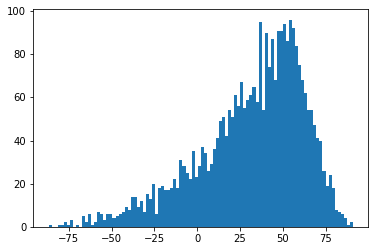

In [11]:
df['vote_diff'] = df['r_vote_percent']- df['d_vote_percent'] 

n_bins = 100
heights, bins, _ = plt.hist('vote_diff', data=df, bins=n_bins) # get positions and heights of bars

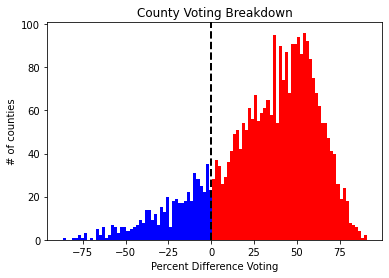

In [12]:
bin_width = np.diff(bins)[0]
bin_pos = bins[:-1] + bin_width / 2

plt.figure()
#break up color at cutoff
mask = (bin_pos >= 0)

# plot data with colors
plt.bar(bin_pos[mask], heights[mask], width=bin_width, color='red')
plt.bar(bin_pos[~mask], heights[~mask], width=bin_width, color='blue')

#labels
plt.title('County Voting Breakdown')
plt.xlabel("Percent Difference Voting")
plt.ylabel("# of counties")
plt.axvline(x=0, linestyle='--',linewidth=2, color='black')

plt.show()

The graph above shows the counties and how severely they vote one direction. A -25 would correlate to a county that votes 25% more Democraft. A 50 means the county voted 50% more republican.As you can see there are a lot more counties that vote republican. This should not be a surpise if you look at this map from 2016. <br>
![GitHub Logo](vote_map.png) <br>
The presidential elections are a lot closer because a lot of the democratic counties have a much higher population. This is strictly percentage not number of votes.

### Summary Tables ###
Examing the data a bit more closely

In [13]:
# setting display to 2 decinmals
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df[['total_cases','population','vote_diff']].describe()

,total_cases,population,vote_diff
count,3114.00,3114.00,3114.00
mean,271635.13,105263.55,31.71
std,1136971.70,334837.46,30.76
min,0.00,169.00,-86.77
25%,13518.50,11128.75,14.67
50%,44518.50,26163.00,37.86
75%,139418.00,68904.75,54.61
max,31779237.00,10039107.00,90.97


In [14]:
# adding column because this makes more sense to me
df['cases_per_capita'] = df['total_cases']/df['population']
df.head()

,countyFIPS,County Name,State,population,total_cases,d_vote_percent,r_vote_percent,vote_diff,cases_per_capita
0,1001,Autauga County,AL,55869,187911,23.77,72.77,49.00,3.36
1,1003,Baldwin County,AL,223234,545470,19.39,76.55,57.16,2.44
2,1005,Barbour County,AL,24686,100237,46.53,52.10,5.57,4.06
3,1007,Bibb County,AL,22394,70606,21.25,76.40,55.15,3.15
4,1009,Blount County,AL,57826,151652,8.43,89.33,80.90,2.62


In [15]:
## checking created columns too
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(df['cases_per_capita'].describe())

count   3114.00
mean       2.05
std        1.73
min        0.00
25%        0.96
50%        1.60
75%        2.64
max       25.34
Name: cases_per_capita, dtype: float64


## Linear Models ##
Here I am going to implement linear models using statsmodels in Python. First I am going to do a straight up linear regression without changing the data. Then I am going to divide total cases by population and do a regresssion on cases per capita.
<br>

### Model 1 ###

In [16]:
X_1 = df[['vote_diff', 'population']]
Y_1 = df['total_cases']

X_1 = sm.add_constant(X_1) # adding a constant
model_1 = sm.OLS(Y_1, X_1).fit()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:            total_cases   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                 1.019e+04
Date:                Thu, 03 Dec 2020   Prob (F-statistic):               0.00
Time:                        19:02:45   Log-Likelihood:                -44691.
No. Observations:                3114   AIC:                         8.939e+04
Df Residuals:                    3111   BIC:                         8.941e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.135e+04   1.19e+04     -6.819      0.0

### Model 2 ###

In [17]:
X_2 = df['vote_diff']
Y_2 = df['cases_per_capita']

X_2 = sm.add_constant(X_2) # adding a constant
model_2 = sm.OLS(Y_2, X_2).fit()
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:       cases_per_capita   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     175.0
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           6.62e-39
Time:                        19:02:45   Log-Likelihood:                -6038.2
No. Observations:                3114   AIC:                         1.208e+04
Df Residuals:                    3112   BIC:                         1.209e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4651      0.043     56.915      0.0

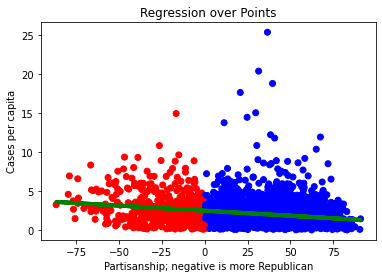

In [29]:
pred = model_2.predict(X_2)

color = np.where(df['vote_diff'] < 0 ,'red','blue')
plt.scatter(X_2['vote_diff'], Y_2,  c=color)
plt.plot(X_2['vote_diff'],pred, linewidth=4, color='green')

plt.title('Regression over Points')
plt.xlabel('Partisanship; negative is more Republican')
plt.ylabel('Cases per capita')
plt.show()

## Multicollinearity ##
Testing for multicollinearity with the variance inflation factor test.

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#creating function to find VIF
def vif(X):
    vif=pd.DataFrame()
    vif['variables'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

#model 1
print(vif(X_1))
print()
#model 2
print(vif(X_2))

    variables  VIF
0       const 2.59
1   vote_diff 1.14
2  population 1.14

   variables  VIF
0      const 2.06
1  vote_diff 1.00


## Serial Correlation Test ##
Performing a Durbin Watson test to check for serial correlation. 

In [24]:
from statsmodels.stats.stattools import durbin_watson


print("Model 1 DW:",durbin_watson(model_1.resid))

print("Model 2 DW:", durbin_watson(model_2.resid))


Model 1 DW: 1.8472963836647807
Model 2 DW: 1.3999465825951618


## Heteroskedasticity ##
Performing a breusch-pagan test

In [25]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

#perform Bresuch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(model_1.resid, model_1.model.exog)

lzip(names, test)

[('Lagrange multiplier statistic', 498.3603758083305),
 ('p-value', 6.059257284070845e-109),
 ('f-value', 296.37093634771037),
 ('f p-value', 1.532288523310646e-118)]

In [26]:
test = sms.het_breuschpagan(model_2.resid, model_2.model.exog)

lzip(names, test)

[('Lagrange multiplier statistic', 7.1945665673610435),
 ('p-value', 0.007312465102452193),
 ('f-value', 7.206595854601014),
 ('f p-value', 0.007302115523552889)]